##Table of Contents

Understand the Problem Statement
1. Tweets Preprocessing and Cleaning
Story Generation and Visualization from Tweets
Extracting Features from Cleaned Tweets
Model Building: Sentiment Analysis


## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)

In [3]:
pwd

'C:\\Users\\sreekanth\\Python_Training_Dec_2019\\Django\\projects\\NLP Sentiment Analysis'

## Importing the dataset

In [4]:
data = pd.read_csv("sentiment.tsv",sep = "\t")
data.columns = ['label','body_text']
data.head(7)

label                                          body_text
0   pos  having a vodka tonic and looking forward to go...
1   pos  @ddlovatofans1neg1 Could you follow me please....
2   pos  @jordanknight for once.................. PLEAS...
3   neg  Had a dream about a walk in fast food resturau...
4   pos  @TroyBrownBBNews Yes... For a &quot;friend&quot; 
5   pos                       Packing for work expierance 
6   neg  hates @internet @explrer (angry)(angry) **but ...

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

label                                          body_text
0      1  having a vodka tonic and looking forward to go...
1      1  @ddlovatofans1neg1 Could you follow me please....
2      1  @jordanknight for once.................. PLEAS...
3      0  Had a dream about a walk in fast food resturau...
4      1  @TroyBrownBBNews Yes... For a &quot;friend&quot;

## Cleaning of Data

In [6]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

## Remove twitter handles (@user)

In [7]:

data['tidy_tweet'] = np.vectorize(remove_pattern)(input_txt=data['body_text'],pattern="@[\w]*")
data.head()

label                                          body_text  \
0      1  having a vodka tonic and looking forward to go...   
1      1  @ddlovatofans1neg1 Could you follow me please....   
2      1  @jordanknight for once.................. PLEAS...   
3      0  Had a dream about a walk in fast food resturau...   
4      1  @TroyBrownBBNews Yes... For a &quot;friend&quot;    

                                          tidy_tweet  
0  having a vodka tonic and looking forward to go...  
1   Could you follow me please.I would really app...  
2   for once.................. PLEASE TELL US WHY...  
3  Had a dream about a walk in fast food resturau...  
4                   Yes... For a &quot;friend&quot;

## Remove special characters, numbers, punctuations

In [8]:
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
data.head()

label                                          body_text  \
0      1  having a vodka tonic and looking forward to go...   
1      1  @ddlovatofans1neg1 Could you follow me please....   
2      1  @jordanknight for once.................. PLEAS...   
3      0  Had a dream about a walk in fast food resturau...   
4      1  @TroyBrownBBNews Yes... For a &quot;friend&quot;    

                                          tidy_tweet  
0  having a vodka tonic and looking forward to go...  
1   Could you follow me please I would really app...  
2   for once                   PLEASE TELL US WHY...  
3  Had a dream about a walk in fast food resturau...  
4                   Yes    For a  quot friend quot

## Tokenize the tweets

In [9]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())  #  split  work with , 
tokenized_tweet.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

In [10]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

In [11]:
len(tokenized_tweet)

2000

## Joining the tokenized word in the same data

In [12]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])  #  join ,
data['tidy_tweet'] = tokenized_tweet
data.head()

label                                          body_text  \
0      1  having a vodka tonic and looking forward to go...   
1      1  @ddlovatofans1neg1 Could you follow me please....   
2      1  @jordanknight for once.................. PLEAS...   
3      0  Had a dream about a walk in fast food resturau...   
4      1  @TroyBrownBBNews Yes... For a &quot;friend&quot;    

                                          tidy_tweet  
0  have a vodka tonic and look forward to go to s...  
1  could you follow me pleas I would realli appre...  
2  for onc pleas tell US whi u were think of thi ...  
3  had a dream about a walk in fast food resturau...  
4                          ye for a quot friend quot

In [2]:
####Story Generation and Visualization from Tweets


In this section, we will explore the cleaned tweets text. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Do not limit yourself to only these methods told in this tutorial, feel free to explore the data as much as possible.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

What are the most common words in the entire dataset?
What are the most common words in the dataset for negative and positive tweets, respectively?
How many hashtags are there in a tweet?
Which trends are associated with my dataset?
Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

## Adding other column for length of the tweet and punctuation

In [15]:
#import string
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*10

In [16]:
data['body_len'] = data['body_text'].apply(lambda x:len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x:count_punct(x))
data.head()

#data.head(15)

label                                          body_text  \
0      1  having a vodka tonic and looking forward to go...   
1      1  @ddlovatofans1neg1 Could you follow me please....   
2      1  @jordanknight for once.................. PLEAS...   
3      0  Had a dream about a walk in fast food resturau...   
4      1  @TroyBrownBBNews Yes... For a &quot;friend&quot;    

                                          tidy_tweet  body_len  punct%  
0  have a vodka tonic and look forward to go to s...        92     1.1  
1  could you follow me pleas I would realli appre...        66     4.5  
2  for onc pleas tell US whi u were think of thi ...        81    27.2  
3  had a dream about a walk in fast food resturau...        96     1.0  
4                          ye for a quot friend quot        44    18.2

## Generating word cloud for data

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

In [18]:
!pip install wordcloud

In [ ]:
#from wordcloud import WordCloud

In [46]:
data['tidy_tweet'].head()

0    have a vodka tonic and look forward to go to s...
1    could you follow me pleas I would realli appre...
2    for onc pleas tell US whi u were think of thi ...
3    had a dream about a walk in fast food resturau...
4                            ye for a quot friend quot
Name: tidy_tweet, dtype: object

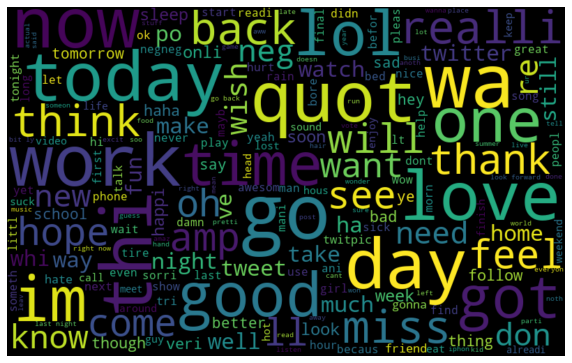

In [19]:
#matplotlib
all_words = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#all_words

In [49]:
#data['tidy_tweet'][data['label']==1]

## Wordcloud for negative tweets

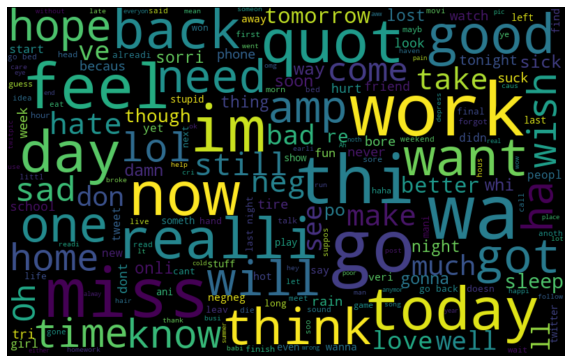

In [20]:
#label ==0 neg, label==1 is pos
negative_words = ' '.join([text for text in data['tidy_tweet'][data['label']==0]])
wordcloud = WordCloud(width=800, height = 500, random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

For instance, given below is a tweet from our dataset: 

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [21]:
# function to collect hashtags
def hashtag_extract(x):
    hashtag = []
    # loop over the words
    for i in x:
        ht = re.findall(r"#(\w+)",i)  #findall(pattern, input)
        hashtag.append(ht)
    return hashtag

In [50]:
data['tidy_tweet'][data['label']==0].head()

3     had a dream about a walk in fast food resturau...
6     hate angri angri but no choic http plurk com p...
7     I said I go out for eat negneg p m I disappoin...
8     yeah they won t do the surgeri till the cold i...
10    Am in the place call negut OF now where take m...
Name: tidy_tweet, dtype: object

In [22]:
# extract hash from no racist/sexist tweets
HT_regular = hashtag_extract(data['tidy_tweet'][data['label']==1])  #hashtag_extract(x)
# positive
HT_negative = hashtag_extract(data['tidy_tweet'][data['label']==0])

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [23]:
#nltk.FreqDist

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d.head(10)

Hashtag  count
0        github      1
1            fb      2
2  stupidgalaev      1
3        nswdet      1
4           bgt      1

In [52]:
#d.head(10)

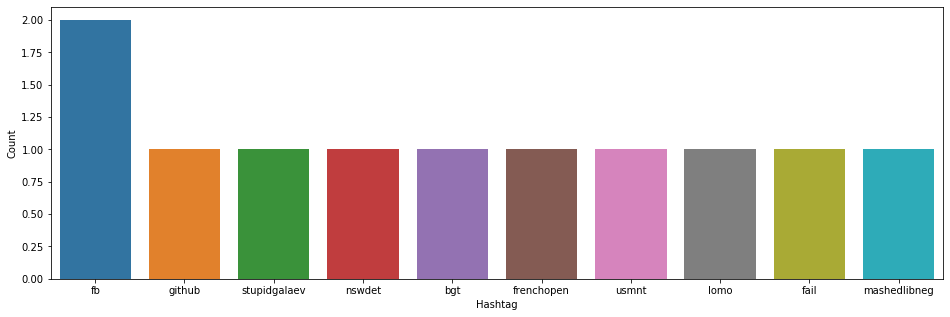

In [24]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

## Histogram for Negative tweets

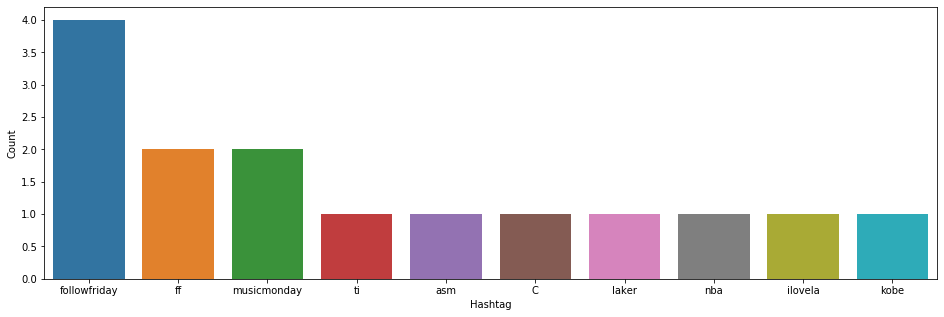

In [25]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()